In [135]:
# Data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly as pl
import plotly.express as px
import plotly.graph_objects as go

import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='mculyak', api_key='SWSFr80ah8CWGmHhGgE3')

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, DoubleType

# stats
import scipy.stats as ss
from statsmodels.stats.proportion import proportion_confint
# Helpers
import os
import json
import re
import wordcloud
# External libraries
# import tldextract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from empath import Empath
lexicon = Empath()

In [ ]:
conf = pyspark.SparkConf().setMaster("local[32]").setAll([
    ('spark.driver.memory','40G'),
    ('spark.driver.maxResultSize', '40G'),
    ('spark.ui.port', 4866),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
])


spark = SparkSession.builder.config(conf=conf).config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.4').getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR') # ERROR, WARN, INFO, DEBUG, ...
spark

In [157]:
DATA_DIR = '../data'

In [3]:
quotes_disamb = spark.read.parquet(DATA_DIR + 'quotes_disamb.parquet')
speaker_attributes = spark.read.parquet(DATA_DIR 'speaker_attributes_labels.parquet')
profanity = spark.read.parquet(DATA_DIR + 'profanity_expanded.parquet')
empath = spark.read.parquet(DATA_DIR + 'empath_ultimate.parquet')

In [8]:
qb_all = quotes_disamb\
            .join(profanity, on='quoteID')\
            .join(speaker_attributes, speaker_attributes.id == quotes_disamb.qid) # Joining everything

In [164]:
gender_profanity = profanity_dist_by_attribute(qb_all, 'gender')
non_profane_counts = gender_profanity.loc[gender_profanity.profanity == 0, ['gender', 'count']]
profane_counts = gender_profanity.loc[gender_profanity.profanity == 1, ['gender', 'count']]
gender_general_dist = gender_profanity.groupby('gender').sum().reset_index()

All the plots created here are hosted on chart studio so they do not appear in the notebook, but can be seen in the data story.

## Gender distributions in profane quotes

In [63]:
layout = go.Layout(
    title='Gender distribution in profane quotes',
)

fig = go.Figure(data=[go.Pie(labels=list(profane_counts.gender),
                             values=profane_counts['count'], hole=.7)], layout=layout)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')

py.iplot(fig, filename='profanity_gender_donut')

## General gender distribution

In [173]:
layout = go.Layout(
    title='Gender distribution in Quotebank',
)

fig = go.Figure(data=[go.Pie(labels=list(gender_general_dist.gender),
                             values=gender_general_dist['count'], hole=.7)], layout=layout)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')

py.iplot(fig, filename='gender_general_donut')

## Genders by profanity

In [168]:
average_profanity_gender = qb_all.select(f.explode('gender').alias('gender'), 'profanity')\
                            .groupby('gender')\
                            .agg(f.avg('profanity').alias('average_profanity'))\
                            .toPandas()

profane_non_profane = profane_counts.merge(non_profane_counts, on='gender')


n_quotes = (profane_non_profane['count_x'] + profane_non_profane['count_y']).reset_index(drop=True)
profane_counts = profane_counts.reset_index(drop=True)

gender_profanity_CI_lower, gender_profanity_CI_upper = proportion_confint(profane_counts['count'], n_quotes, alpha=0.05, method='wilson')
# Wilson confidence interval is better at handling low proportions https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
gender_avg_prof_df = pd.DataFrame({'gender': profane_counts.gender,
                   'avg': profane_counts['count'] / n_quotes, 
                   'lower_CI': gender_profanity_CI_lower,
                   'upper_CI': gender_profanity_CI_upper}).sort_values('avg', ascending=False)


In [197]:
palette = px.colors.diverging.Portland
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Profanity',
    marker_color=palette[1],
    x=gender_avg_prof_df.gender, y=gender_avg_prof_df.avg,
    error_y=dict(type='data',
                 symmetric=False,
                 array=gender_avg_prof_df.upper_CI - gender_avg_prof_df.avg,
                 arrayminus=gender_avg_prof_df.avg - gender_avg_prof_df.lower_CI)
))

fig.update_layout(
    title='Average profanity per gender',
    xaxis_title='Gender',
    yaxis_title='Average profanity',
)

py.iplot(fig, filename='gender_avg_prof_perc')

## Profanities per speaker

In [765]:
lower_title = f.udf(lambda x: x.lower().title(), StringType()) # Eliminating duplicate speakers
speaker_profanity = qb_all\
                        .select(lower_title(f.col('speaker')).alias('speaker'), 'quotation', 'profanity')\
                        .groupby('speaker')\
                        .agg(f.avg('profanity').alias('avg_profanity'),
                             f.count('quotation').alias('count'))\
                        .where(f.col('count') >= 5000)\ # Selecting only the speakers with more than 5000 quotes to avoid noise
                        .sort('avg_profanity', ascending=False)\
                        .toPandas()

In [768]:
highest_profanity_25 = speaker_profanity.head(25) # We consider top 25 speakers with the highest profanity
highest_profanity_25

,speaker,avg_profanity,count
0,Kodak Black,0.392314,1249
1,Soulja Boy,0.379893,1124
2,Nate Diaz,0.310805,2471
3,Cardi B,0.306744,15984
4,Joe Budden,0.302017,2033
5,Azealia Banks,0.287788,3996
6,Kid Rock,0.285516,2161
7,Tory Lanez,0.285497,1317
8,50 Cent,0.283798,5740
9,Megan Thee Stallion,0.280269,1338


In [769]:
most_quoted_25 = speaker_profanity.sort_values('count', ascending=False).head(25) # We consider top 25 most quoted speakers
most_quoted_25

,speaker,avg_profanity,count
2469,President Donald Trump,0.012245,316795
1306,Donald Trump,0.023355,253655
7467,Narendra Modi,0.003047,147346
2262,President Trump,0.013450,146612
8210,Pope Francis,0.002578,103580
4537,Hillary Clinton,0.006118,95788
2609,Bernie Sanders,0.011565,84308
6460,President Barack Obama,0.003899,75667
5477,Jose Mourinho,0.004893,65811
613,Rodrigo Duterte,0.043368,60944


In [770]:
# We can observe that Donald Trump and Barack Obama appear multiple times, so we aggregate their counts 
speaker_profanity[speaker_profanity['speaker'].str.contains('Trump')]

,speaker,avg_profanity,count
1306,Donald Trump,0.023355,253655
1571,Donald J. Trump,0.019406,6699
1579,Donald Trump Jr. .,0.019345,7237
1977,Eric Trump,0.015371,3513
2262,President Trump,0.013450,146612
2322,Ivana Trump,0.013170,1063
2469,President Donald Trump,0.012245,316795
2711,Melania Trump,0.011004,21811
2785,President Donald J. Trump,0.010724,3357
2886,Lara Trump,0.010267,1948


In [771]:
speaker_profanity[speaker_profanity['speaker'].str.contains('Obama')]

,speaker,avg_profanity,count
2613,Michelle Obama,0.011546,14550
3550,Barack Obama,0.008138,26910
4774,President Obama,0.005771,53193
6460,President Barack Obama,0.003899,75667


In [772]:
speaker_profanity['profanity'] = speaker_profanity['avg_profanity'] * speaker_profanity['count']


for name in ('Donald J. Trump', 'President Trump', 'President Donald Trump', 'President Donald J. Trump'):
    speaker_profanity.loc[speaker_profanity['speaker'] == 'Donald Trump', 'profanity'] += speaker_profanity.loc[speaker_profanity['speaker'] == name, 'profanity'].values[0]
    speaker_profanity.loc[speaker_profanity['speaker'] == 'Donald Trump', 'count'] += speaker_profanity.loc[speaker_profanity['speaker'] == name, 'count'].values[0]
    speaker_profanity = speaker_profanity.loc[speaker_profanity['speaker'] != name]

In [773]:
for name in ('President Obama', 'President Barack Obama'):
    speaker_profanity.loc[speaker_profanity['speaker'] == 'Barack Obama', 'profanity'] += speaker_profanity.loc[speaker_profanity['speaker'] == name, 'profanity'].values[0]
    speaker_profanity.loc[speaker_profanity['speaker'] == 'Barack Obama', 'count'] += speaker_profanity.loc[speaker_profanity['speaker'] == name, 'count'].values[0]
    speaker_profanity = speaker_profanity.loc[speaker_profanity['speaker'] != name]
    
speaker_profanity['avg_profanity'] = speaker_profanity['profanity'] / speaker_profanity['count']

In [774]:
most_quoted_25 = speaker_profanity.sort_values('count', ascending=False).head(25)
most_quoted_25

,speaker,avg_profanity,count,profanity
1306,Donald Trump,0.016422,727118,11941.0
3550,Barack Obama,0.005271,155770,821.0
7467,Narendra Modi,0.003047,147346,449.0
8210,Pope Francis,0.002578,103580,267.0
4537,Hillary Clinton,0.006118,95788,586.0
2609,Bernie Sanders,0.011565,84308,975.0
5477,Jose Mourinho,0.004893,65811,322.0
613,Rodrigo Duterte,0.043368,60944,2643.0
3673,Jurgen Klopp,0.007844,59922,470.0
9651,Benjamin Netanyahu,0.001599,58774,94.0


In [775]:
speaker_profanity_CI_lower, speaker_profanity_CI_upper = proportion_confint(speaker_profanity['profanity'],
                                                                          speaker_profanity['count'],
                                                                          alpha=0.05, method='wilson')

## Speaker profanities
Here we plot the average profanity for top 25 speakers with the highest average profanity (a speaker has to be quoted at least 5000 times to be considered) along with the 95% intervals.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Profanity percentage',
    marker_color=palette[1],
    x=highest_profanity_25.speaker,
    y=highest_profanity_25['avg_profanity'],
    visible=True,
    error_y=dict(type='data',
                 symmetric=False,
                 array=speaker_profanity_CI_upper - highest_profanity_25['avg_profanity'],
                 arrayminus=highest_profanity_25['avg_profanity'] - speaker_profanity_CI_lower),
))


fig.update_layout(
    xaxis_title='Speaker',
    yaxis_title='Profanity percentage',
    barmode='overlay'
)

fig.add_trace(go.Bar(
    name='All quotes',
    marker_color=palette[1],
    x=most_quoted_25.speaker,
    y=most_quoted_25['count'],
    visible=False
))

fig.add_trace(go.Bar(
    name='Profane quotes',
    marker_color=palette[4],
    x=most_quoted_25.speaker,
    y=most_quoted_25['avg_profanity'] * most_quoted_25['count'],
    text=most_quoted_25['avg_profanity'].apply(lambda x: '{0:1.1f}%'.format(x * 100)),
    visible=False
))


fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8)

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='right',
            x=0.205,
            y=1.21,
            showactive=True,
            buttons=list(
                [
                    dict(
                        label='Highest profanity percentage',
                        method='update',
                        args=[
                            {'visible': [True, False, False]},
                            {'yaxis': {'title': 'Profanity percentage'}},
                        ]
                    ),
                    dict(
                        label='Most quoted',
                        method='update',
                        args=[
                            {'visible': [False, True, True]},
                            {'yaxis': {'title': 'Number of quotations', 'type':'log'}},
                        ],
                    ),
                ]
            ),
        )
    ]
)


py.iplot(fig, filename='speaker_avg_prof_perc')

## Empath aggression category per gender

In [ ]:
gender_aggressions = quotes_disamb\
                        .join(empath, on='quoteID')\
                        .join(speaker_attributes, on=quotes_disamb.qid == speaker_attributes.id)\
                        .select(f.explode('gender').alias('gender'), 'aggression')\
                        .groupby('gender').agg(f.avg('aggression').alias('aggression'),
                                               f.count('gender').alias('count'),
                                               f.stddev_samp('aggression').alias('aggression_sem'))\
                        .toPandas()\
                        .sort_values('aggression', ascending=False)

In [777]:
gender_aggressions_CI_lower, gender_aggressions_CI_upper = ss.t.interval(0.95, gender_aggressions['count'] - 1,
                                                                         gender_aggressions.aggression,
                                                                         gender_aggressions.aggression_std / np.sqrt(gender_aggressions['count'] - 1))

/home/culjak/.conda/envs/speaker-disambiguation/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning:

invalid value encountered in multiply

/home/culjak/.conda/envs/speaker-disambiguation/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



In [160]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Aggression',
    marker_color=palette[1],
    x=gender_aggressions.gender, y=gender_aggressions.aggression,
    error_y=dict(type='data',
                 symmetric=False,
                 array=gender_aggressions_CI_upper - gender_aggressions.aggression,
                 arrayminus=np.minimum(gender_aggressions.aggression - gender_aggressions_CI_lower, gender_aggressions.aggression))
))

fig.update_layout(
    xaxis_title='Gender',
    yaxis_title='Average aggression',
)
# fig.show()
py.iplot(fig, filename='gender_aggression')


# Web domain analysis
## Profanity and censorship per news domain
As for the speakers, here we also consider the domains with a high number of quotations and plot top 25 ones with the highest average profanity and top 25 with the most quotations featured. We also look into censorship.

In [9]:
unique_domains = f.udf(lambda x: list(set(x)), ArrayType(StringType()))

media_profanity = qb_all.select(f.explode(unique_domains('domains')).alias('domain'), 'profanity', 'censored')\
                    .groupby('domain')\
                    .agg(f.sum('profanity').alias('profanity'),
                         f.sum('censored').alias('censored'),
                         f.avg('profanity').alias('profanity_avg'),
                         f.avg('censored').alias('censorship'),
                         f.count('domain').alias('count')).toPandas()

In [26]:
media_profanity['censored_profanities'] = media_profanity['censored'] / media_profanity['profanity']

most_quotations_25 = media_profanity.sort_values('count', ascending=False)[media_profanity['count'] > 5000].head(25)
highest_profanity_25 = media_profanity.sort_values('profanity_avg', ascending=False)[media_profanity['count'] > 5000].head(25)
most_profane_quotations_25 = media_profanity.sort_values('profanity', ascending=False)[media_profanity['profanity'] > 500].head(25)
highest_censorship_25 = media_profanity.sort_values('censored_profanities', ascending=False)[media_profanity['profanity'] > 500].head(25)
lowest_censorship_25 = media_profanity.sort_values('censored_profanities', ascending=True)[media_profanity['profanity'] > 500].head(25)

domain_profanity_CI_lower, domain_profanity_CI_upper = proportion_confint(highest_profanity_25['profanity'],
                                                                          highest_profanity_25['count'],
                                                                          alpha=0.05, method='wilson')

domain_censorship_high_CI_lower, domain_censorship_high_CI_upper = proportion_confint(highest_censorship_25['censored'],
                                                                          highest_censorship_25['profanity'],
                                                                          alpha=0.05, method='wilson')

domain_censorship_low_CI_lower, domain_censorship_low_CI_upper = proportion_confint(lowest_censorship_25['censored'],
                                                                          lowest_censorship_25['profanity'],
                                                                          alpha=0.05, method='wilson')

/tmp/ipykernel_518562/769228727.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_518562/769228727.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_518562/769228727.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_518562/769228727.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_518562/769228727.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
highest_censorship_25
domain_censorship_high_CI_lower

In [166]:
palette = px.colors.diverging.Portland

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Profanity percentage',
    marker_color=palette[1],
    x=highest_profanity_25.domain,
    y=highest_profanity_25['profanity_avg'],
    visible=False,
    error_y=dict(type='data',
                 symmetric=False,
                 array=domain_profanity_CI_upper - highest_profanity_25['profanity_avg'],
                 arrayminus=highest_profanity_25['profanity_avg'] - domain_profanity_CI_lower),
))

fig.update_yaxes(title='Profanity percentage')
fig.update_layout(uniformtext_minsize=8)

fig.add_trace(go.Bar(
    name='All quotes',
    marker_color=palette[1],
    x=most_quotations_25.domain,
    y=most_quotations_25['count'],
    visible=True
))

fig.add_trace(go.Bar(
    name='Profane quotes',
     marker_color=palette[4],
    x=most_quotations_25.domain,
    y=most_quotations_25['profanity'],
    text=most_quotations_25['profanity_avg'].apply(lambda x: '{0:1.1f}%'.format(x * 100)),
    textposition='outside',
    visible=True
))

fig.update_layout(
    xaxis_title='Domain',
    yaxis_title='Number of quotations',
    barmode='overlay'
)

fig.update_yaxes(type='log')



fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='right',
            x=0.205,
            y=1.25,
            showactive=True,
            buttons=list(
                [
                    dict(
                        label='Most quotations',
                        method='update',
                        args=[
                            {'visible': [False, True, True]},
                            {'yaxis': {'title': 'Number of quotations',
                                       'type': 'log'}}
                        ],
                    ),
                    dict(
                        label='Highest profanity percentage',
                        method='update',
                        args=[
                            {'visible': [True, False, False]},
                            {'yaxis': {'title': 'Profanity percentage'}}
                        ],
                    ),
                    
                ]
            ),
        )
    ]
)
# py.iplot(fig, filename='domain_avg_prof_perc')
a = 1

In [169]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Censorship percentage',
    marker_color=palette[1],
    x=highest_censorship_25.domain,
    y=highest_censorship_25['censored_profanities'],
    visible=True,
    error_y=dict(type='data',
                 symmetric=False,
                 array=domain_censorship_high_CI_upper - highest_censorship_25['censored_profanities'],
                 arrayminus=highest_censorship_25['censored_profanities'] - domain_censorship_high_CI_lower),
))
fig.update_yaxes(title='Censorship percentage')


fig.add_trace(go.Bar(
    name='Profane quotes',
    marker_color=palette[1],
    x=most_profane_quotations_25.domain,
    y=most_profane_quotations_25['profanity'],
    visible=False
))

fig.add_trace(go.Bar(
    name='Censored profane quotes',
    marker_color=palette[4],
    x=most_profane_quotations_25.domain,
    y=most_profane_quotations_25['censored'],
    visible=False,
    text=(most_profane_quotations_25['censored_profanities']).apply(lambda x: '{0:1.1f}%'.format(x * 100)),
    textposition='outside'
))


fig.add_trace(go.Bar(
    name='Censorship percentage',
    marker_color=palette[1],
    x=lowest_censorship_25.domain,
    y=lowest_censorship_25['censored_profanities'],
    visible=False,
    error_y=dict(type='data',
                 symmetric=False,
                 array=domain_censorship_low_CI_upper - lowest_censorship_25['censored_profanities'],
                 arrayminus=lowest_censorship_25['censored_profanities'] - domain_censorship_low_CI_lower),
))


fig.update_layout(
    xaxis_title='Domain',
    barmode='overlay'
)

fig.update_yaxes(type='log')


fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='right',
            x=0.305,
            y=1.31,
            showactive=True,
            buttons=list(
                [
                    dict(
                        label='Highest censorship percentage',
                        method='update',
                        args=[
                            {'visible': [True, False, False, False]},
                            {'yaxis': {'title': 'Censorship percentage'}}
                        ],
                    ),
                    dict(
                        label='Most profane quotations',
                        method='update',
                        args=[
                            {'visible': [False, True, True, False]},
                            {'yaxis': {'title': 'Number of quotations'}}

                        ],
                    ),
                     dict(
                        label='Lowest censorship percentage',
                        method='update',
                        args=[
                            {'visible': [False, False, False, True]},
                            {'yaxis': {'title': 'Censorship percentage'}}

                        ],
                    ),
                ]
            ),
        )
    ]
)

# fig.show()
py.iplot(fig, filename='domain_avg_cen_perc')

## Empath
Here we plot Empath's lexical categories for profane quotations, and the difference between the aggregated scores of profane and non-profane quotations.

In [62]:
categories = sorted(list(lexicon.analyze('').keys()))
empath_agg = empath.join(profanity, on='quoteID').groupby('profanity').agg(*[f.mean(category).alias(category) for category in categories]).toPandas()
empath_agg = empath_agg.set_index('profanity')

In [111]:
empath_agg = empath_agg.append(empath_agg.iloc[0] - empath_agg.iloc[1], ignore_index=True)
empath_agg = empath_agg.sort_values(0, axis=1)


,anonymity,exotic,exasperation,superhero,anticipation,medieval,irritability,ship,neglect,tool,...,listen,ridicule,communication,pain,positive_emotion,children,violence,speaking,swearing_terms,negative_emotion
0,0.000037,0.000118,0.000134,0.000139,0.000148,0.000150,0.000173,0.000176,0.000228,0.000266,...,0.004281,0.004380,0.004694,0.004854,0.005118,0.005443,0.005693,0.006126,0.023128,0.026574
1,0.000090,0.000227,0.000188,0.000155,0.000369,0.000105,0.000194,0.000337,0.000396,0.000390,...,0.002959,0.000253,0.004418,0.002572,0.007072,0.004523,0.003446,0.004818,0.000343,0.005993
2,-0.000054,-0.000109,-0.000054,-0.000016,-0.000221,0.000045,-0.000020,-0.000160,-0.000167,-0.000124,...,0.001322,0.004127,0.000275,0.002282,-0.001954,0.000920,0.002247,0.001308,0.022785,0.020581


In [112]:
fig = go.Figure(go.Bar(
            y=empath_agg.columns,
            x=empath_agg.iloc[0],
            orientation='h',
            marker_color = palette[4]))

fig.update_layout(
    autosize=False,
    width=500,
    height=3000,
)


py.iplot(fig, filename='empath_profane')

In [114]:
empath_agg = empath_agg.sort_values(2, axis=1)
fig = go.Figure(go.Bar(
            y=empath_agg.columns,
            x=empath_agg.iloc[2],
            orientation='h',
            marker_color=np.where(empath_agg.iloc[2] < 0, palette[1], palette[4])
))

fig.update_layout(
    autosize=False,
    width=500,
    height=3000,

)


py.iplot(fig, filename='empath_diff')

## Word clouds

In [115]:
profane_quotations = spark.read.parquet(DATA_DIR + 'profane.parquet')

tokenize_udf = f.udf(word_tokenize, ArrayType(StringType()))
word_counts = profane_quotations.select(f.explode(tokenize_udf('quotation')).alias('word'))\
                    .where(f.col('profanity') == 1)\
                    .groupby('word')\
                    .count().toPandas()

In [ ]:
word_counts.word = word_counts.word.str.lower()
word_counts = word_counts.groupby('word').sum()

In [129]:
with open('bad-words.txt', 'r') as f:
    bad_words = f.readlines()
    bad_words = set([word.strip('\n ') for word in bad_words])


In [470]:
word_counts = word_counts.to_dict('index')
most_frequent_profanities = {k: v['count'] for k, v in word_counts.items() if k in bad_words}
most_frequent_non_profanities = {k: v['count'] for k, v in word_counts.items() if k not in bad_words and k not in stop_words and re.match('^[a-zA-Z]{2,}$', k)}

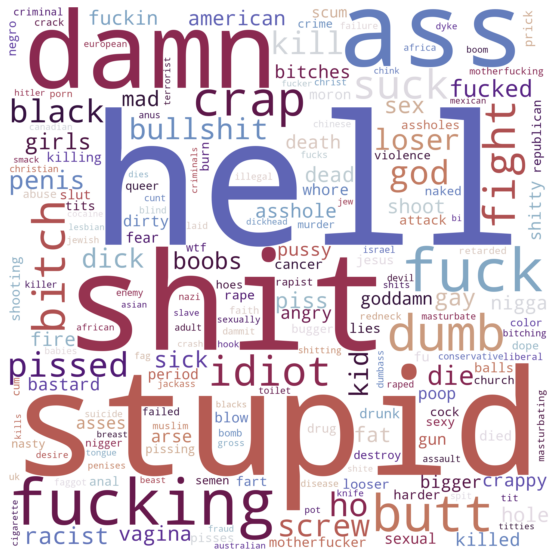

In [735]:
# Most frequent profane words in profane quotes
wc = wordcloud.WordCloud(width=2000, height=2000, background_color='white', colormap='twilight_shifted').generate_from_frequencies(most_frequent_profanities)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('profane_quotes_profane_words.png')

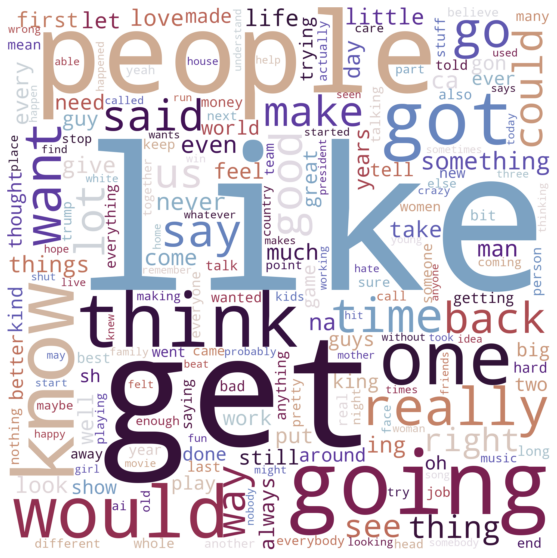

In [736]:
# Most frequent non-profane words in profane quotes
wc = wordcloud.WordCloud(width=2000, height=2000, background_color='white', colormap='twilight_shifted').generate_from_frequencies(most_frequent_non_profanities)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('profane_quotes_non-profane_words.png')